<a href="https://colab.research.google.com/github/dchirosca/fake-news-detection/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("dplyr")
install.packages("tidytext")
install.packages("SnowballC")
install.packages("uuid")
install.packages("ggplot2")
install.packages("tm")
library(dplyr)
library(tidytext)
library(SnowballC)
library(uuid)
library(ggplot2)
library(tm)

# Reading the data
fake_dt<-read.csv("fake.csv")
fake_dt$id<-sapply(1:nrow(fake_dt), function(x) UUIDgenerate())
true_dt<-read.csv("true.csv")
true_dt$id<-sapply(1:nrow(true_dt), function(x) UUIDgenerate())
head(fake_dt)
head(true_dt)
dim(fake_dt)[1]+dim(true_dt)[1]

# Exploratory data analysis
fake_sub<-fake_dt %>% count(subject, sort = TRUE)
fake_sub # there are 6 topics in the fake news dataframe
fake_sub %>%
  ggplot(aes(subject, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()
true_sub<-true_dt %>% count(subject, sort = TRUE)
true_sub # there are only 2 topics in the true news dataframe
true_sub %>%
  ggplot(aes(subject, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()

# Viewing the most commonly used words in the datasets
fake_uw<-fake_dt %>% unnest_tokens(word, text) %>% anti_join(stop_words) %>% count(word, sort = TRUE)
top_20_words <- fake_uw %>%
  top_n(20, n)
# Plotting the top 20 mostly used words
ggplot(top_20_words, aes(x = reorder(word, n), y = n)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Top 20 most used words in fake news",
       x = "Words",
       y = "Frequency") +
  theme_minimal()+
  theme(plot.title = element_text(hjust = 0.5))

true_uw<-true_dt %>% unnest_tokens(word, text) %>% anti_join(stop_words) %>% count(word, sort = TRUE)
top_20_words <- true_uw %>%
  top_n(20, n)
# Plotting the top 20 mostly used words
ggplot(top_20_words, aes(x = reorder(word, n), y = n)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Top 20 most used words in real news",
       x = "Words",
       y = "Frequency") +
  theme_minimal()+
  theme(plot.title = element_text(hjust = 0.5))

# We notice that there are very similar words used in both datasets and the subject identified is not very suggestive in both cases, so we will go into topic modelling

# Preparing for topic modelling
label<-rep(x = 1, times = dim(fake_dt)[1])
fake_dt<-cbind(fake_dt, label)
label<-rep(x = 0, times = dim(true_dt)[1])
true_dt<-cbind(true_dt, label)
dt<-rbind(fake_dt, true_dt)
dt_tokens<-dt %>% unnest_tokens(word, text) %>% anti_join(stop_words)
# Creating the document-term matrix for the fake-news dataframe
dt_matrix<-dt_tokens %>%
  count(id, word) %>%
  cast_dtm(document = id, term = word, value = n, weighting = tm::weightTf)
dt_matrix

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘janeaustenr’, ‘tokenizers’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate




1. **Joining with by = join_by(word):**
This message likely indicates that you joined some datasets or performed some operation that involved merging by the column named word. This is a message from the dplyr package or a similar package that indicates how the join operation was performed.

2. **DocumentTermMatrix (documents: 44267, terms: 200474):**
Documents: 44267 - The number of documents in the corpus.
Terms: 200474 - The number of unique terms (words) in the corpus.

3. **Non-/sparse entries: 6187958/886819460:**
Non-sparse entries: 6187958 - The number of non-zero entries in the matrix. These represent the actual occurrences of terms in the documents.
Sparse entries: 886819460 - The number of zero entries in the matrix. These represent the terms that do not appear in certain documents.

4. **Sparsity: 100%:**
This indicates the percentage of zero entries in the matrix. A sparsity of 100% suggests that the matrix is very sparse, meaning most of the entries are zero. This is common in text data because most words do not appear in most documents.

5. **Maximal term length: 1043:**
This indicates the length of the longest term (word) in your corpus. It appears that there is at least one very long word with 1043 characters, which might be unusual and worth investigating.

6. **Weighting: term frequency (tf):**
The term frequency (tf) weighting means that the values in the matrix represent the raw count of how often each term appears in each document.

In [ ]:
# Latent dirichet allocation (LDA)
system2('sudo', 'apt-get install libgsl0-dev') # to allow for the instalation of topicmodels package in Colab
install.packages("topicmodels")
install.packages("reshape2")
library(topicmodels)
library(tidyverse)

news_lda<-LDA(dt_matrix, k = 5, method = "Gibbs", control = list(seed = 1111)) # k = 5 topics
news_lda
news_betas<-tidy(news_lda, matrix = "beta")
news_betas # the higher the beta of a term, the more the term is associated with one topic
# Printing the top 10 terms for each topic
top_terms <- news_betas %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)
top_terms
# Getting the document-topic probabilities
doc_topics <- tidy(news_lda, matrix = "gamma")
# Assigning the most likely topic to each document
assigned_topics<-doc_topics %>%
  group_by(document) %>%
  top_n(1, gamma) %>%
  ungroup()
assigned_topics<-as.data.frame(assigned_topics)
# Merging the assigned topics back to the original dataframe
df<-merge(x = dt, y = assigned_topics, by.x = "id", by.y = "document")
df<-subset(df, select=-c(gamma)) # removing the gamma column since it is not neccesary anymore
head(df, 10)
# Recreating the original two-split dataframes
fake_dt<-df %>% filter(label == 1)
fake_dt$topic<-as.character(fake_dt$topic)
true_dt<-df %>% filter(label == 0)
true_dt$topic<-as.character(true_dt$topic)
# Analyzing how many news are categoriez with what topic
fake_dt %>% count(topic) # 1 = 3434, 2 = 9750, 3 = 6956, 4 = 2123, 5 = 970
fake_dt %>% count(topic) %>%
  ggplot(aes(topic, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()
# Contingency table
fake_subject_summary<-table(fake_dt$subject, fake_dt$topic)
print(fake_subject_summary) # we notice that the topic modelling identified other 5 topics that the original ones, so we will continue to topic model for a more efficient split of the data

true_dt %>% count(topic) # 1 = 2476, 2 = 1467, 3 = 1242, 4 = 6026, 5 = 10378
true_dt %>% count(topic) %>%
  ggplot(aes(topic, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()
# Contingency table
true_subject_summary<-table(true_dt$subject, true_dt$topic)
print(true_subject_summary)1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘modeltools’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ NLP::annotate() masks ggplot2::annotate()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Feature engineering

In order to prepare for the machine learning modelling, we need to create some features out of the original dataset to understand the variables that characterize fake news. These features can be of three types as it follows:

1.   **Stylistic features**

These refer to the actual style of writing of the news and will have features such as: word count, words per sentence, time orientation (focused on past or future), number of personal pronouns and impersonal pronouns, number of quantifying words, number of comparison words, number of negations, number of slang terms (if they exist), number of interrogations, etc.

2.   **Psychology features**

These features will analyze the feeling created by the text.

3.   **Complexity features**

These features will take into consideration the complexity of the text, hence how easy it is for it to be read and understood. Complexity features include and are not limited to: flesch kincaid grade level, gunning fog index, average length of each word, simple measure of gobbledygook, etc.



## Stylistic features

In [ ]:
# Identifying stylistic features
# Loading the spacy packages

install.packages('reticulate') # install reticulate to interface R and Python
library(reticulate) # Load reticulate library
install_miniconda(update = T, force = T) # Use reticulate to install miniconda (comment out if conda has already been installed)
install.packages("spacyr")
library(spacyr)
spacy_install(prompt=FALSE) # !!!! this creates problems if run a second time in an RStudio Cloud project, so only run once !!!!
install.packages("quanteda")
library(quanteda)
spacy_initialize(model = "en_core_web_sm")

# Parsing the text using spacyr
parsed_text<-spacy_parse(df$text, tag = TRUE)

# Number of personal pronouns
pers_pronouns<-parsed_text %>% group_by(doc_id) %>% filter(tag == "PRP" & pos == "PRON") %>% count(doc_id)
# Number of impersonal pronouns
imp_pronouns<-parsed_text %>% group_by(doc_id) %>% filter(tag == "NN" & pos == "PRON") %>% count(doc_id)
# Number of quantifying words
quant<-parsed_text %>% group_by(doc_id) %>% filter(tag == "JJ" & pos == "ADJ") %>% count(doc_id)
# Number of comparison words
comp<-parsed_text %>% group_by(doc_id) %>% filter(tag == "JJR" & pos == "ADJ") %>% count(doc_id)
# Number of negations
neg<-parsed_text %>% group_by(doc_id) %>% filter(tag == "RB" & pos == "PART") %>% count(doc_id)
# Number of interrogations
inter<-parsed_text %>% group_by(doc_id) %>% filter(tag == "WRB" & pos == "SCONJ") %>% count(doc_id)
# Number of past-orinted verbs
past<-parsed_text %>% group_by(doc_id) %>% filter(tag %in% c("VBD", "VBN") & pos == "VERB") %>% count(doc_id)
# Number of future-oriented verbs
future<-parsed_text %>% group_by(doc_id) %>% filter(tag != "VBD" & pos == "VERB") %>% count(doc_id)
# Number of punctuation
punc<-parsed_text %>% group_by(doc_id) %>% filter(pos == "PUNCT") %>% count(doc_id)

new_id<-c()
for(i in 1:dim(df)[1]){
  new_id[i]<-paste0("text",i)
}
df<-cbind(df, new_id)

# Merging no of personal pronouns
df<-merge(x = df, y = pers_pronouns, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, pers_pronouns = n)
# Merging no of impersonal pronouns
df<-merge(x = df, y = imp_pronouns, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, impers_pronouns = n)
# Merging no of quantifying words
df<-merge(x = df, y = quant, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, quant = n)
# Merging no of comparison words
df<-merge(x = df, y = comp, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, comp = n)
# Merging no of negations
df<-merge(x = df, y = neg, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, neg = n)
# Merging no of interrogations
df<-merge(x = df, y = inter, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, inter = n)
# Merging no of past-oriented words
df<-merge(x = df, y = past, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, past_w = n)
# Merging no of future-oriented words
df<-merge(x = df, y = future, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, future_w = n)
# Merging no of punctuations
df<-merge(x = df, y = punc, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, punct = n)

# Replacing NAs generated by the merges with 0s
df[is.na(df)]<-0
df<-subset(df, select=-c(id)) # removing id column since it is no longer of use and new_id will be used instead

install.packages("quanteda.textstats")
library(quanteda.textstats)
# Adding the number of words
df$word_count<-ntoken(tokens(df$text))
# Adding the number of sentences
df$sentence_count<-lengths(tokens(df$text, what = "sentence"))

means<-df %>%
  group_by(label) %>%
  summarise(pers_pron = mean(pers_pronouns),
            impers_pron = mean(impers_pronouns),
            quant = mean(quant),
            comp = mean(comp),
            neg = mean(neg),
            inter = mean(inter),
            past_w = mean(past_w),
            future_w = mean(future_w),
            punct = mean(punct)
            )
print(means)

# write.csv(df, file = "df1.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’


* Installing Miniconda -- please wait a moment ...

* Downloading 'https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh' ...

+ /usr/bin/bash /tmp/RtmpwG6yvW/Miniconda3-latest-Linux-x86_64.sh -b -u -p '/root/.local/share/r-miniconda'

+ /root/.local/share/r-miniconda/bin/conda update --yes --name base conda

+ /root/.local/share/r-miniconda/bin/conda create --yes --name r-reticulate 'python=3.10' numpy --quiet -c conda-forge

* Miniconda has been successfully installed at "~/.local/share/r-miniconda".



[1] "/root/.local/share/r-miniconda"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in spacy_install(prompt = FALSE):
“spacyr 1.3 removed a number of arguments to simplify this function.”


Using Python: /usr/local/bin/python
Creating virtual environment 'r-spacyr' ... 


+ /usr/local/bin/python -m venv /root/.virtualenvs/r-spacyr



Done!
Installing packages: pip, wheel, setuptools


+ /root/.virtualenvs/r-spacyr/bin/python -m pip install --upgrade pip wheel setuptools



Installing packages: numpy


+ /root/.virtualenvs/r-spacyr/bin/python -m pip install --upgrade --no-user numpy



Virtual environment 'r-spacyr' successfully created.
Using virtual environment 'r-spacyr' ...


+ /root/.virtualenvs/r-spacyr/bin/python -m pip install --upgrade --no-user spacy

Executing command:
/root/.virtualenvs/r-spacyr/bin/python -m spacy download en_core_web_sm

Installation of spaCy version 3.7.5 complete.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ISOcodes’, ‘fastmatch’, ‘stopwords’, ‘RcppArmadillo’


Package version: 4.0.2
Unicode version: 14.0
ICU version: 70.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘package:tm’:

    stopwords


The following objects are masked from ‘package:NLP’:

    meta, meta<-


successfully initialized (spaCy Version: 3.7.5, language model: en_core_web_sm)



## Complexity features

In [ ]:
# df<-read.csv("df1.csv")

fk<-textstat_readability(df$text, measure = "Flesch.Kincaid")
fog<-textstat_readability(df$text, measure = "FOG")
smog<-textstat_readability(df$text, measure = "SMOG")
syl<-textstat_readability(df$text, measure = "meanWordSyllables")
df<-cbind(df, fk$Flesch.Kincaid, fog$FOG, smog$SMOG, syl$meanWordSyllables)
colnames(df)
df<-rename(df,
  flesch_kincaid = `fk$Flesch.Kincaid`,
  fog = `fog$FOG`,
  smog = `smog$SMOG`,
  syl = `syl$meanWordSyllables`
  )

means<-df %>%
  group_by(label) %>%
  summarise(flesch_kincaid = mean(flesch_kincaid),
            fog = mean(fog),
            smog = mean(smog),
            syl = mean(syl),
            word_count = mean(word_count),
            sentence_count = mean(sentence_count)
            )
print(means)

# write.csv(df, file = "df2.csv")

# A tibble: 2 × 7
  label flesch_kincaid   fog  smog   syl word_count sentence_count
  <dbl>          <dbl> <dbl> <dbl> <dbl>      <dbl>          <dbl>
1     0           13.9  17.3  15.2  1.68       431.           16.2
2     1           15.0  18.2  15.2  1.62       479.           15.9


## Psychology features

In [ ]:
# df<-read.csv("df2.csv")

# Bing dictionary
df_sentiment<-df %>%
  unnest_tokens(word, text) %>%
  inner_join(get_sentiments("bing"), by = "word") %>%
  group_by(new_id) %>%
  summarise(sentiment_score = sum(ifelse(sentiment == "positive", 1, ifelse(sentiment == "negative", -1, 0))))
df_sentiment
df<-df %>% left_join(df_sentiment, by = "new_id")
head(df,5)

colnames(df)

means<-df %>%
  group_by(label) %>%
  summarise(sentiment_mean = mean(sentiment_score, na.rm = TRUE))
print(means)

# write.csv(df, file = "df3.csv")

# A tibble: 2 × 2
  label sentiment_mean
  <dbl>          <dbl>
1     0         -0.605
2     1         -0.915


## Date feature extraction

[1] "character"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“ 46 failed to parse.”


[1]    83    84  1059  1839  5006  7590  7853 10198 10556 10780 11492 11742
[13] 11983 12547 12734 13278 13492 14152 14778 16174 16608 17337 18844 19919
[25] 20992 22001 23172 24056 24061 25128 25787 26540 27197 28595 30984 31539
[37] 33066 34138 36213 37372 37735 38054 38774 41996 42748 44622

[1] "https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/"
[1] "https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/"
[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg"
[1] "18-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "16-Feb-18"
[1] "19-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "14-Feb-18"
[1] "https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg"
[1] "16-Feb-18"
[1] "18-Feb-18"
[1] "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg"
[1] "19-Feb-18"
[1] "18-Feb-

Warning message:
“ 36 failed to parse.”


[1]  1057  1837  5004  7850 10195 10553 10777 11738 11979 12543 12730 13274
[13] 13488 14148 14774 16170 16604 17333 18840 19915 21996 23167 24055 25122
[25] 25781 27190 28588 30977 33058 36204 37363 37726 38045 38765 42738 44612

[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "18-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "16-Feb-18"
[1] "19-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "14-Feb-18"
[1] "16-Feb-18"
[1] "18-Feb-18"
[1] "19-Feb-18"
[1] "18-Feb-18"
[1] "15-Feb-18"
[1] "18-Feb-18"
[1] "MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]"
[1] "15-Feb-18"
[1] "19-Feb-18"
[1] "16-Feb-18"
[1] "17-Feb-18"
[1] "17-Feb-18"
[1] "17-Feb-18"
[1] "16-Feb-18"
[1] "16-Feb-18"
[1] "18-Feb-18"


[1] 25781

Warning message:
“ 35 failed to parse.”


[1]  1057  1837  5004  7850 10195 10553 10777 11738 11979 12543 12730 13274
[13] 13488 14148 14774 16170 16604 17333 18840 19915 21996 23167 24055 25122
[25] 27189 28587 30976 33057 36203 37362 37725 38044 38764 42737 44611

[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "18-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "15-Feb-18"
[1] "16-Feb-18"
[1] "19-Feb-18"
[1] "18-Feb-18"
[1] "16-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "15-Feb-18"
[1] "17-Feb-18"
[1] "14-Feb-18"
[1] "16-Feb-18"
[1] "18-Feb-18"
[1] "19-Feb-18"
[1] "18-Feb-18"
[1] "18-Feb-18"
[1] "MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]"
[1] "15-Feb-18"
[1] "19-Feb-18"
[1] "16-Feb-18"
[1] "17-Feb-18"
[1] "17-Feb-18"
[1] "17-Feb-18"
[1] "16-Feb-18"
[1] "16-Feb-18"
[1] "18-Feb-18"


Warning message:
“All formats failed to parse. No formats found.”


[1] "2015-12-20" "2017-10-06" "2016-01-15" "2016-05-06" "2016-12-17"
    [6] "2017-11-09" "2017-03-16" "2017-10-14" "2015-12-18" "2016-12-22"
   [11] "2017-12-01" "2016-01-21" "2017-12-20" "2017-03-10" "2017-12-16"
   [16] "2017-01-04" "2017-06-26" "2017-10-20" "2017-04-15" "2016-01-11"
   [21] "2017-10-20" "2016-04-27" "2017-08-25" "2016-08-10" "2016-03-13"
   [26] "2017-01-01" "2017-09-25" "2017-01-09" "2017-12-22" "2017-02-01"
   [31] "2017-09-11" "2017-03-30" "2017-10-31" "2017-09-22" "2016-07-11"
   [36] "2017-11-02" "2016-10-31" "2017-06-22" "2017-12-06" "2017-02-28"
   [41] "2017-02-28" "2016-08-21" "2017-12-12" "2017-03-13" "2017-10-22"
   [46] "2016-11-08" "2016-10-17" "2017-11-09" "2017-11-10" "2017-02-17"
   [51] "2016-09-09" "2015-07-13" "2016-07-31" "2017-09-29" "2017-10-10"
   [56] "2017-11-28" "2017-11-20" "2017-08-13" "2017-06-22" "2017-09-19"
   [61] "2017-09-06" "2017-10-30" "2016-11-20" "2017-02-12" "2017-05-26"
   [66] "2016-04-05" "2016-06-09" "2017-05-12" "2017-06-08" "2015-06-11"
   [71] "2016-05-15" "2015-10-05" "2017-09-14" "2017-02-02" "2017-10-23"
   [76] "2016-01-25" "2016-09-19" "2017-10-02" "2016-01-26" "2017-06-16"
   [81] "2017-11-14" "2016-11-23" "2016-05-10" "2016-02-17" "2017-09-29"
   [86] "2017-09-29" "2017-01-16" "2017-04-19" "2017-06-14" "2016-02-26"
   [91] "2016-10-13" "2017-10-16" "2017-10-18" "2016-01-22" "2016-01-22"
   [96] "2016-08-21" "2015-07-27" "2017-02-15" "2017-12-05" "2017-09-21"
  [101] "2017-01-02" "2017-12-26" "2017-10-23" "2015-05-22" "2016-09-12"
  [106] "2017-01-22" "2017-01-22" "2017-07-30" "2016-08-26" "2017-10-06"
  [111] "2015-08-17" "2017-09-20" "2016-05-05" "2016-08-19" "2016-07-15"
  [116] "2016-07-24" "2016-06-03" "2017-04-25" "2016-11-18" "2017-01-18"
  [121] "2017-07-21" "2017-12-07" "2016-05-12" "2016-05-05" "2017-04-05"
  [126] "2017-09-19" "2016-05-21" "2016-10-13" "2017-07-13" "2017-12-11"
  [131] "2016-05-21" "2017-11-06" "2017-01-27" "2017-12-04" "2017-09-26"
  [136] "2017-09-16" "2017-01-29" "2017-06-09" "2016-04-04" "2016-10-19"
  [141] "2016-04-01" "2017-10-02" "2017-05-09" "2017-12-13" "2017-10-20"
  [146] "2016-01-20" "2016-09-20" "2016-09-10" "2017-02-05" "2016-04-20"
  [151] "2016-01-04" "2017-10-22" "2016-02-14" "2016-04-11" "2017-04-18"
  [156] "2015-11-04" "2017-09-07" "2017-09-05" "2017-11-22" "2017-07-06"
  [161] "2017-01-21" "2017-02-23" "2017-02-23" "2017-05-13" "2017-10-28"
  [166] "2016-02-28" "2017-02-06" "2016-10-21" "2017-07-09" "2016-10-25"
  [171] "2017-06-20" "2016-05-16" "2017-01-17" "2017-12-08" "2017-09-30"
  [176] "2017-11-12" "2017-05-09" "2016-12-12" "2017-07-18" "2017-01-19"
  [181] "2017-11-19" "2016-03-07" "2017-11-23" "2017-11-15" "2017-11-15"
  [186] "2016-11-19" "2015-11-28" "2016-10-20" "2017-01-10" "2017-10-08"
  [191] "2016-07-20" "2016-01-19" "2017-07-09" "2017-11-28" "2016-09-30"
  [196] "2017-12-15" "2016-01-29" "2017-10-06" "2017-09-14" "2017-12-20"
  [201] "2017-10-10" "2017-08-04" "2016-04-20" "2015-11-23" "2017-05-31"
  [206] "2016-12-21" "2016-07-27" "2017-05-20" "2016-03-09" "2017-10-25"
  [211] "2016-11-30" "2016-01-26" "2016-03-21" "2017-05-11" "2016-11-28"
  [216] "2015-11-14" "2017-08-11" "2016-06-27" "2017-12-20" "2017-09-01"
  [221] "2016-10-30" "2016-06-29" "2016-08-28" "2017-02-03" "2016-11-07"
  [226] "2017-11-09" "2015-11-30" "2017-10-19" "2017-10-02" "2017-11-29"
  [231] "2016-05-05" "2016-11-03" "2016-09-23" "2015-10-05" "2016-11-17"
  [236] "2016-02-19" "2017-12-06" "2016-12-04" "2017-11-03" "2016-08-26"
  [241] "2017-12-16" "2016-10-27" "2017-03-08" "2016-09-13" "2017-11-13"
  [246] "2017-11-15" "2017-10-16" "2016-08-30" "2017-12-22" "2017-04-03"
  [251] "2017-08-13" "2017-02-02" "2016-08-25" "2017-04-14" "2017-09-18"
  [256] "2017-08-03" "2017-01-30" "2016-12-15" "2017-04-07" "2016-09-19"
  [261] "2016-12-29" "2017-12-12" "2017-07-19" "2017-03-06" "2017-11-21"
  [266] "2016-12-05" "2016-06-19" "2016-02-02" "2017-12-25" "2016-03-01"
  [271] "2017-11-05" "2016-02-26" "2017-03-31" "2017-06-01" "2

[1] "Date"

max_value
<int>
151


[1] "2017-11-02" "2017-11-29" "2017-12-14"

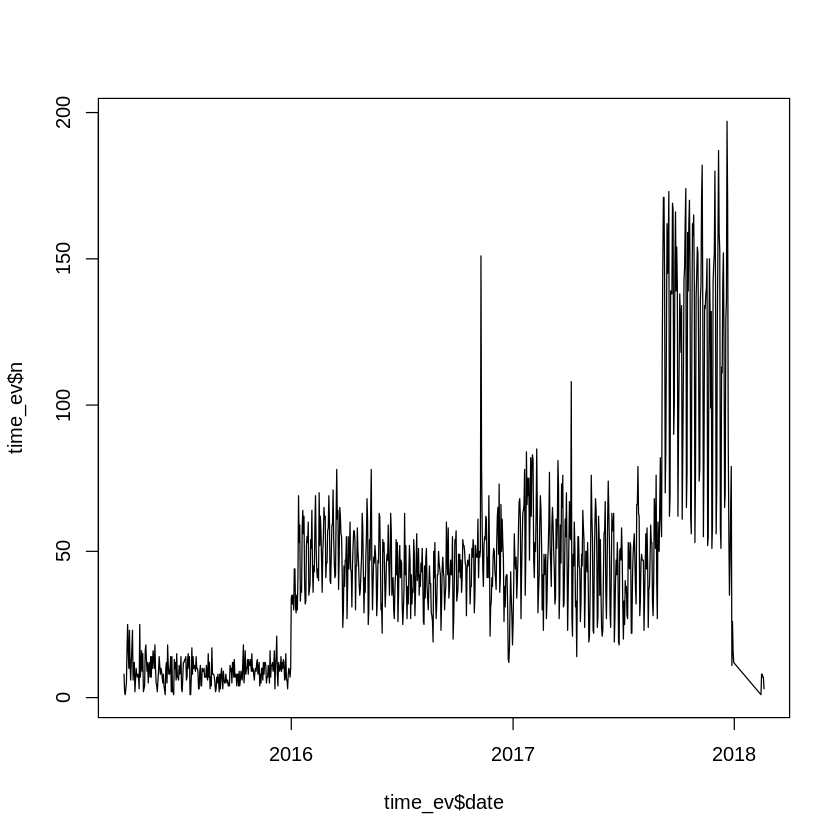

In [ ]:
class(df$date) # observing that the date is storred as character, transforming it to date
install.packages("lubridate")
library(lubridate)

dates_c<-mdy(df$date) # some dates failed to parse
na_positions<-which(is.na(dates_c))
na_positions
for(i in 1:length(na_positions)){
  print(df$date[na_positions[i]])
} # noticing there are some rows with weird link values, eliminating those

url_pattern <- "http[s]?://"
df<-df %>%
  filter(!grepl(url_pattern, date))

# Repeating the process
dates_c<-mdy(df$date) # some dates failed to parse
na_positions<-which(is.na(dates_c))
na_positions
for(i in 1:length(na_positions)){
  print(df$date[na_positions[i]])
} # noticing the 25th NA position contains invalid text, removing this as well
na_positions[25] # row 30550
df<-df[-na_positions[25],]

# Repeating the process for the last time
dates_c<-mdy(df$date) # some dates failed to parse
na_positions<-which(is.na(dates_c))
na_positions
for(i in 1:length(na_positions)){
  print(df$date[na_positions[i]])
} # noticing that the dates that failed now have a similar format that can be parsed easily into date with some modifications
for(i in 1:length(na_positions)){
  dates_c[na_positions[i]]<-dmy(df$date[na_positions[i]])
}
dates_c # all dates have been properly converted
class(dates_c) # the vector is of date class
# replacing the original column with the new one
df$date<-dates_c
time_ev<-df %>% count(date)
plot(x = time_ev$date, y = time_ev$n, type = "l") # noticing the volume of news data increased in 2016, which is an election year in the USA
# also noticing a peak in 2016
time_ev %>%
  filter(year(date) == 2016) %>%
  summarise(max_value = max(n)) # 152 news
time_ev$date[which(time_ev$n == 152)] # the max value of 152 news was recorded on 2016-11-09, the day when Donald Trump is elected president

# Splitting the date into day, month, year and adding the columns to the dataframe
df$day<-day(df$date)
df$month<-month(df$date)
df$year<-year(df$date)

## Title feature extraction

In [ ]:
# Parsing the text using spacyr
parsed_titles<-spacy_parse(df$title, tag = TRUE)

# Number of personal pronouns
t_pers_pronouns<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "PRP" & pos == "PRON") %>% count(doc_id)
# Number of impersonal pronouns
t_imp_pronouns<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "NN" & pos == "PRON") %>% count(doc_id)
# Number of quantifying words
t_quant<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "JJ" & pos == "ADJ") %>% count(doc_id)
# Number of comparison words
t_comp<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "JJR" & pos == "ADJ") %>% count(doc_id)
# Number of negations
t_neg<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "RB" & pos == "PART") %>% count(doc_id)
# Number of interrogations
t_inter<-parsed_titles %>% group_by(doc_id) %>% filter(tag == "WRB" & pos == "SCONJ") %>% count(doc_id)
# Number of past-orinted verbs
t_past<-parsed_titles %>% group_by(doc_id) %>% filter(tag %in% c("VBD", "VBN") & pos == "VERB") %>% count(doc_id)
# Number of future-oriented verbs
t_future<-parsed_titles %>% group_by(doc_id) %>% filter(tag != "VBD" & pos == "VERB") %>% count(doc_id)
# Number of punctuation
t_punc<-parsed_titles %>% group_by(doc_id) %>% filter(pos == "PUNCT") %>% count(doc_id)

# Re-generating the new id column
new_id<-c()
for(i in 1:dim(df)[1]){
  new_id[i]<-paste0("text",i)
}
df$new_id<-new_id

# Merging no of personal pronouns
df<-merge(x = df, y = t_pers_pronouns, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_pers_pronouns = n)
# Merging no of impersonal pronouns
df<-merge(x = df, y = t_imp_pronouns, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_impers_pronouns = n)
# Merging no of quantifying words
df<-merge(x = df, y = t_quant, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_quant = n)
# Merging no of comparison words
df<-merge(x = df, y = t_comp, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_comp = n)
# Merging no of negations
df<-merge(x = df, y = t_neg, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_neg = n)
# Merging no of interrogations
df<-merge(x = df, y = t_inter, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_inter = n)
# Merging no of past-oriented words
df<-merge(x = df, y = t_past, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_past_w = n)
# Merging no of future-oriented words
df<-merge(x = df, y = t_future, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_future_w = n)
# Merging no of punctuations
df<-merge(x = df, y = t_punc, by.x = "new_id", by.y = "doc_id", all.x = TRUE)
df<-rename(df, t_punct = n)
# Replacing NAs generated by the merges with 0s
df[is.na(df)]<-0

# Adding the number of words
df$t_word_count<-ntoken(tokens(df$title))
# Adding the number of sentences
df$t_sentence_count<-lengths(tokens(df$title, what = "sentence"))

means<-df %>%
  group_by(label) %>%
  summarise(pers_pron = mean(t_pers_pronouns),
            impers_pron = mean(t_impers_pronouns),
            quant = mean(t_quant),
            inter = mean(t_inter),
            word_count = mean(t_word_count),
            sentence_count = mean(t_sentence_count)
            )
print(means)

# write.csv(df, file = "df4.csv")

# A tibble: 2 × 7
  label pers_pron impers_pron quant   inter word_count sentence_count
  <dbl>     <dbl>       <dbl> <dbl>   <dbl>      <dbl>          <dbl>
1     0    0.0451     0.00171 0.851 0.00727       11.0           1.05
2     1    0.372      0.0207  0.476 0.0996        17.6           1.21


## Preparing the dataset for modeling

In [ ]:
colnames(df)
# keeping only the columns that will be used in the machine learning algorithms
col_to_keep<-c('label','topic','pers_pronouns','impers_pronouns','quant','comp','neg','inter','past_w','future_w',
  'punct','word_count','sentence_count','flesch_kincaid','fog','smog','syl','sentiment_score','day','month','year',
  't_pers_pronouns','t_impers_pronouns','t_quant','t_comp','t_neg','t_inter','t_past_w','t_future_w','t_punct',
  't_word_count','t_sentence_count')
dt<-subset(df, select = col_to_keep)
dim(dt)[1] # 44 805 observations
dim(dt)[2] # 32 features

# write.csv(dt, file = "df_to_model.csv")

# **Random forest with grid search**

The principle of grid search is quite simple: the model will be evaluated over all the combinations passed to the function, using cross-validation.
For this analysis, we will implement random search - this method will not evaluate all the combinations of hyperparameters in the searching space all at once, but it will randomly choose combinations at every iteration. This method has the great advantage of lower computational cost compared to the original grid search method.
We will follow these steps:
*   Find the best number of mtry
*   Find the best number of maxnodes
*   Find the best number of ntrees
*   Evaluate the optimal model

Afterwards, we will also vizualize the importance of the variables.
The best number of mtry, maxnodes and ntrees will be chosen by maximizing the Accuracy generated by the model.
For the evaluation of the model, we will use a **K-fold cross validation**, which will be implemented using the trainControl() function from R. For this function, we will use:
*   **method** = "cv"; this is the method used to resample the dataset and is referring to cross-validation. In cross-validation, the dataset is randomly divided into k subsets (also called folds). For each iteration, one subset is kept as the validation data and the remaining k-1 are used as training data. K results will be obtained and they will be averaged to produce one single estimation.
*   **number** = n; the number of folds to create. We will choose a default number of 10 folds that will offer a good balance between computational efficiency and reliable estimates created by the model
*   **search** = "grid" to use the search grid method

The randomForest algorithm has the following structure in R:
*RandomForest(formula, ntree, mtry, maxnodes)*, where:
*   **formula**: the formula of the fitted model which will be label~. to use the fake/real label as a function of all the features included in the dataset
*   **ntree**: the number of trees in the forest; generally, the more trees, the better the model performance, but the improvements will plateau after a certain point. Usually, a number between 100 and 1000 is used to train random forest models
*   **mtry**: the number of variable candidates draw to feed the algorithm
*   **maxnodes**: the maximum amount of terminal nodes in the forest; large numbers of terminal trees tend to increase the model complexity, but also might lead to overfitting










In [ ]:
install.packages("rlang") # for data pre-processing
install.packages("caret")
install.packages("randomForest")
install.packages("e1071")
library(rlang) # for data pre-processing
library(caret)
library(randomForest)
library(e1071)
options(scipen = 99)

# The training of the model will run slow, so we will try to do a paralel execution
install.packages("doParallel")
library(doParallel)
cores<-detectCores()-1  # Reserving 1 core for the operating system
cl<-makeCluster(cores)
registerDoParallel(cl)

dt<-read.csv("df_to_model.csv")
dt$label<-as.factor(dt$label)
dt<-subset(dt, select = -c(X))

# Random forest -----------------------------------------------------------

# Searching for the best mtry with grid search
set.seed(1234)
tuneGrid<-expand.grid(.mtry = c(10:25)) # starting with one-third of the total number of variables
rf_default<-train(label~.,
                  data = dt,
                  method = "rf",
                  metric = "Accuracy",
                  trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
                  tuneGrid = tuneGrid,
                  importance = TRUE)
print(rf_default)

rf_default$bestTune$mtry # mtry = 13
min(rf_default$results$Accuracy) # the highest Accuracy = 0.9709631

best_mtry<-rf_default$bestTune$mtry
best_mtry<-13

# Searching for the best maxnodes
store_maxnode <- list()
tuneGrid <- expand.grid(.mtry = best_mtry)
for (maxnodes in seq(300, 500, by = 10)) {
    set.seed(1234)
    rf_maxnode <- train(label~.,
        data = dt,
        method = "rf",
        metric = "Accuracy",
        tuneGrid = tuneGrid,
        trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
        importance = TRUE,
        nodesize = 14,
        maxnodes = maxnodes,
        ntree = 300)
    key<-toString(maxnodes)
    store_maxnode[[key]] <- rf_maxnode
}
results_node <- resamples(store_maxnode)
summary(results_node) # maxnodes = 500 has the highest accuracy value of 0.9573708, so we will continue with it

# Searching the best ntrees
store_maxtrees <- list()
tuneGrid <- expand.grid(.mtry = best_mtry)
for (ntree in c(250, 300, 350, 400, 450, 500, 550, 600, 800, 1000, 2000)) {
    set.seed(1234)
    rf_maxtrees <- train(label~.,
        data = dt,
        method = "rf",
        metric = "Accuracy",
        tuneGrid = tuneGrid,
        trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
        importance = TRUE,
        nodesize = 14,
        maxnodes = 500,
        ntree = ntree)
    key <- toString(ntree)
    store_maxtrees[[key]] <- rf_maxtrees
}
results_tree <- resamples(store_maxtrees)
summary(results_tree) # will train a model with ntrees = 2000 which returns an Accuracy of 0.9584868

# Searching the best nodesize
store_nodesize <- list()
tuneGrid <- expand.grid(.mtry = best_mtry)
for (nodesize in c(2:20)) {
    set.seed(1234)
    rf_nodesize <- train(label~.,
        data = dt,
        method = "rf",
        metric = "Accuracy",
        tuneGrid = tuneGrid,
        trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
        importance = TRUE,
        nodesize = nodesize,
        maxnodes = 500,
        ntree = 2000)
    key <- toString(nodesize)
    store_nodesize[[key]] <- rf_nodesize
}
results_tree <- resamples(store_nodesize)
summary(results_tree) # will train a model with nodesize = 17 which returns an accuracy of 0.96221118

# Creating the first model
set.seed(1234)
tuneGrid<-expand.grid(.mtry = best_mtry)
fit_rf<-randomForest(label~.,
    data = dt,
    method = "rf",
    metric = "Accuracy",
    tuneGrid = tuneGrid,
    trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
    importance = TRUE,
    nodesize = 20,
    ntree = 400,
    maxnodes = 500)
summary(fit_rf)
fit_rf$confusion
rf_accuracy<-(fit_rf$confusion[1,1]+fit_rf$confusion[2,2])/dim(dt)[1]
rf_accuracy

install.packages("ggRandomForests")
library(ggRandomForests)
error_plot<-gg_error(fit_rf)
plot(error_plot)
plot(fit_rf)

# Vizualizing variable importance
varImpPlot(fit_rf)


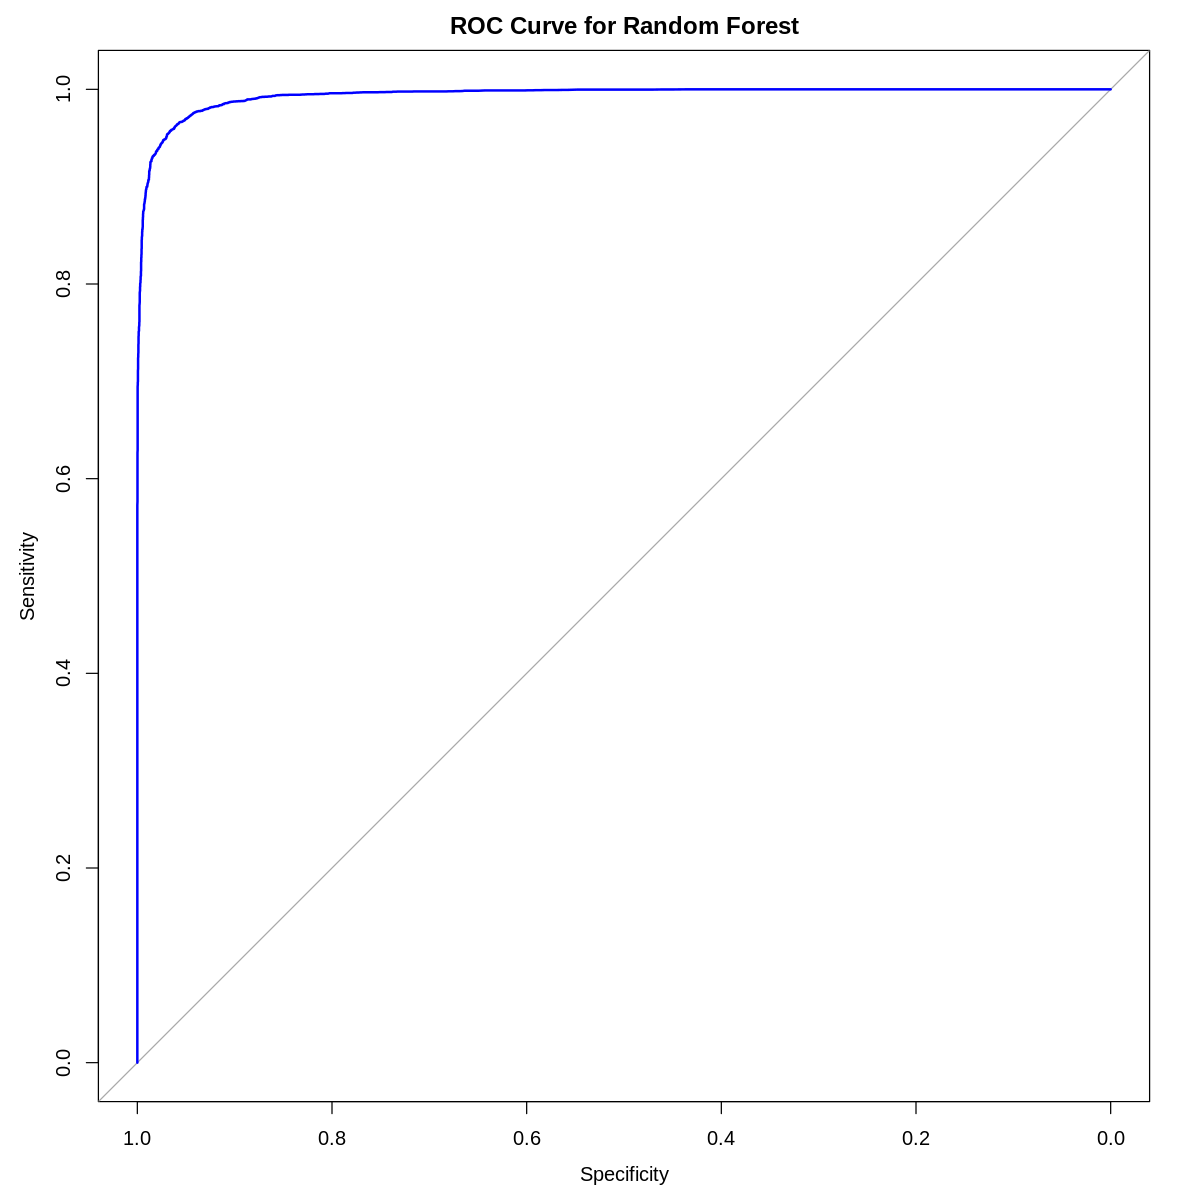

In [ ]:
# The ROC curve for Random Forest

set.seed(1234)
train_indices<-createDataPartition(dt$label, p = 0.7, list = FALSE)
train_data<-dt[train_indices, ]
test_data<-dt[-train_indices, ]
set.seed(1234)
fit_rf <- randomForest(label ~ .,
                       data = train_data,
                       mtry = best_mtry,
                       ntree = 2000,
                       nodesize = 17,
                       maxnodes = 500,
                       importance = TRUE)
rf_probs <- predict(fit_rf, newdata = test_data, type = "prob")[, 2]
roc_curve <- roc(test_data$label, rf_probs)
options(repr.plot.width = 10, repr.plot.height = 10)
plot(roc_curve, col = "blue", main = "ROC Curve for Random Forest")
auc_value <- auc(roc_curve)
print(auc_value)

# XGBoost

In [ ]:
# xgboost -----------------------------------------------------------
install.packages("xgboost")
library(xgboost)
library(plyr)

dt<-read.csv("df_to_model.csv")

# Spliting dataset into trainging and testing subsets
set.seed(1234)
splitIndex<-createDataPartition(dt$label, p = 0.75, list = FALSE) # splitting the dataset in 75-25 training and test
train_data<-dt[splitIndex,]
test_data<-dt[-splitIndex,]

# Separate features and labels
train_labels<-train_data$label
train_data<-train_data[, -which(names(train_data) == "label")]
invalid_label_indices<-which(!(train_labels %in% c(0, 1)))
invalid_label_indices

test_labels<-test_data$label
test_data<-test_data[, -which(names(test_data) == "label")]

# Convert the cleaned dataframe to a Dmatrix
dtrain<-xgb.DMatrix(data = as.matrix(train_data), label = train_labels)
dtest<-xgb.DMatrix(data = as.matrix(test_data), label = test_labels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



integer(0)

# **Training the XGBoost Model**

We will first train one model and then work on optimizing the parameters.
Since our business problem is of classification type, there are multiple options to choose from:
*   **binary:logistic**: logistic regression for binary classification, output probability. This type of objective is generally used for when the problem needs probability scores for the positive class. This is the most common choice for binary classification problems where there is a need to interpret the probability or apply a threshold other than 0.5.
*   **binary:logitraw**: logistic regression for binary classification, output score before logistic transformation. It is used when you want raw scores rather than probabilities.
*   **binary:hinge**: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities. It is generally used for a hard classification decision boundary without probabilities. This is less common and is used when the problem strictly requires binary outcomes and the hinge loss provides better performance for the specific problem.

Due to the objective of the problem being the identification of fake news, we will use both binary:logistic and binary:hinge and compare results

We will start with a learning rate (eta) of 0.3, a maximum depth of a tree of 6

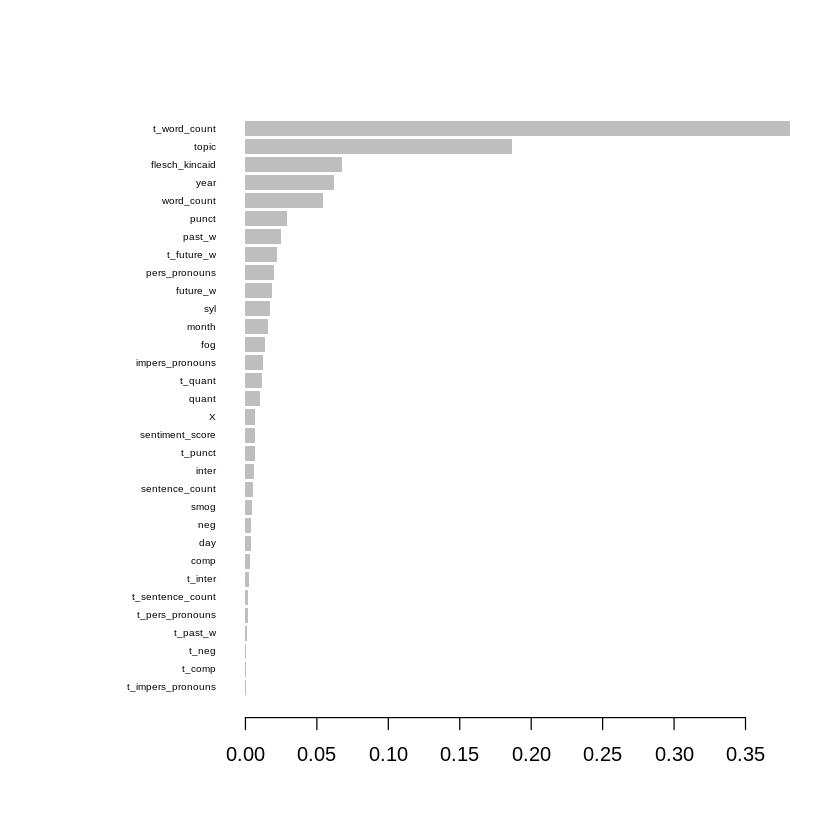

In [ ]:
params<-list(
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  eval_metric = "error"
)

set.seed(1234)  # for reproducibility
xgb_model<-xgb.train(params = params, data = dtrain, nrounds = 1000)
summary(xgb_model)

preds<-predict(xgb_model, dtest)
preds
preds_t<-ifelse(preds >= 0.5, 1, 0)

confusion_matrix<-table(pred = preds_t, true = test_labels)
print(confusion_matrix)
accuracy_1<-(confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
accuracy_1 # accuracy = 0.9803

# Further, we will hyperparameter tune the xgboost model

# creating a grid of hyperparameters
nrounds<-seq(from = 100, to = 1000, by = 100)
eta<-c(0.05, 0.1, 0.3, 0.5)
max_depth<-c(6, 8, 10)
gamma<-c(0, 0.1, 0.2)

accuracy_values<-c()
model_params<-c()
for(i in 1:length(nrounds)){
  for(j in 1:length(eta)){
    for(m in 1:length(max_depth)){
      for(n in 1:length(gamma)){
        params<-list(objective = "binary:logistic",
                      eta = eta[j],
                      max_depth = max_depth[m],
                      gamma = gamma[n]
                    )
        set.seed(1234)  # for reproducibility
        xgb_model<-xgb.train(params, dtrain, nrounds = nrounds[i])
        preds<-predict(xgb_model, dtest)
        preds_t<-ifelse(preds >= 0.5, 1, 0)
        confusion_matrix<-table(pred = preds_t, true = test_labels)
        accuracy_v<-(confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        accuracy_values<-c(accuracy_values, accuracy_v)
        model_params<-c(model_params, paste0("nrounds", nrounds[i], "eta", eta[j], "max_depth", max_depth[m], "gamma", gamma[n]))
      }
    }
  }
}
xgb_models<-data.frame(model_params, accuracy_values)
max(xgb_models$accuracy_values) # accuracy = 0.9813
xgb_models[which.max(xgb_models$accuracy_values),] # nrounds = 800, eta = 0.1, max_depth = 10, gamma = 0

params<-list(
  objective = "binary:logistic",
  eta = 0.1,
  max_depth = 10
)
set.seed(1234)  # for reproducibility
opt_xgb_model<-xgb.train(params, dtrain, nrounds = 800)
preds<-predict(opt_xgb_model, dtest)
preds_t<-ifelse(preds >= 0.5, 1, 0)
confusion_matrix<-table(pred = preds_t, true = test_labels)
confusion_matrix
library(caret)
# Ploting confusion matrix
fourfoldplot(confusion_matrix, color = c("red", "green"), main = "Confusion Matrix")

install.packages("pROC")
library(pROC)
# Create the ROC curve
roc_curve <- roc(test_labels, preds)
plot(roc_curve, col = "blue", main = "ROC Curve for XGBoost")
auc_value<-auc(roc_curve)
print(auc_value) # 0.9978

# Vizualizing variable importance
importance_matrix<-xgb.importance(feature_names = colnames(train_data), model = opt_xgb_model)
xgb.plot.importance(importance_matrix)


# Creating the second model, with a different objective

nrounds<-seq(from = 100, to = 1000, by = 100)
eta<-c(0.05, 0.1, 0.3, 0.5)
max_depth<-c(6, 8, 10)
gamma<-c(0, 0.1, 0.2)

accuracy_values<-c()
model_params<-c()
for(i in 1:length(nrounds)){
  for(j in 1:length(eta)){
    for(m in 1:length(max_depth)){
      for(n in 1:length(gamma)){
        params<-list(objective = "binary:hinge",
                      eta = eta[j],
                      max_depth = max_depth[m],
                      gamma = gamma[n]
                    )
        set.seed(1234)  # for reproducibility
        xgb_model<-xgb.train(params, dtrain, nrounds = nrounds[i])
        preds<-predict(xgb_model, dtest)
        confusion_matrix<-table(pred = preds, true = test_labels)
        accuracy_v<-(confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        accuracy_values<-c(accuracy_values, accuracy_v)
        model_params<-c(model_params, paste0("nrounds", nrounds[i], "eta", eta[j], "max_depth", max_depth[m], "gamma", gamma[n]))
      }
    }
  }
}
xgb_models<-data.frame(model_params, accuracy_values)
max(xgb_models$accuracy_values) # accuracy = 0.9780
xgb_models[which.max(xgb_models$accuracy_values),] # nrounds = 600, eta = 0.05, max_depth = 6, gamma = 0

params<-list(
  objective = "binary:hinge",
  eta = 0.05,
  max_depth = 6
)
set.seed(1234)  # for reproducibility
opt_xgb_model<-xgb.train(params, dtrain, nrounds = 600)
preds<-predict(opt_xgb_model, dtest)
confusion_matrix<-table(pred = preds, true = test_labels)
confusion_matrix
fourfoldplot(confusion_matrix, color = c("red", "green"), main = "Confusion Matrix")

# Create the ROC curve
roc_curve <- roc(test_labels, preds)
plot(roc_curve, col = "blue", main = "ROC Curve for XGBoost")
auc_value<-auc(roc_curve)
print(auc_value) # 0.9781

# Vizualizing variable importance
importance_matrix<-xgb.importance(feature_names = colnames(train_data), model = opt_xgb_model)
xgb.plot.importance(importance_matrix)


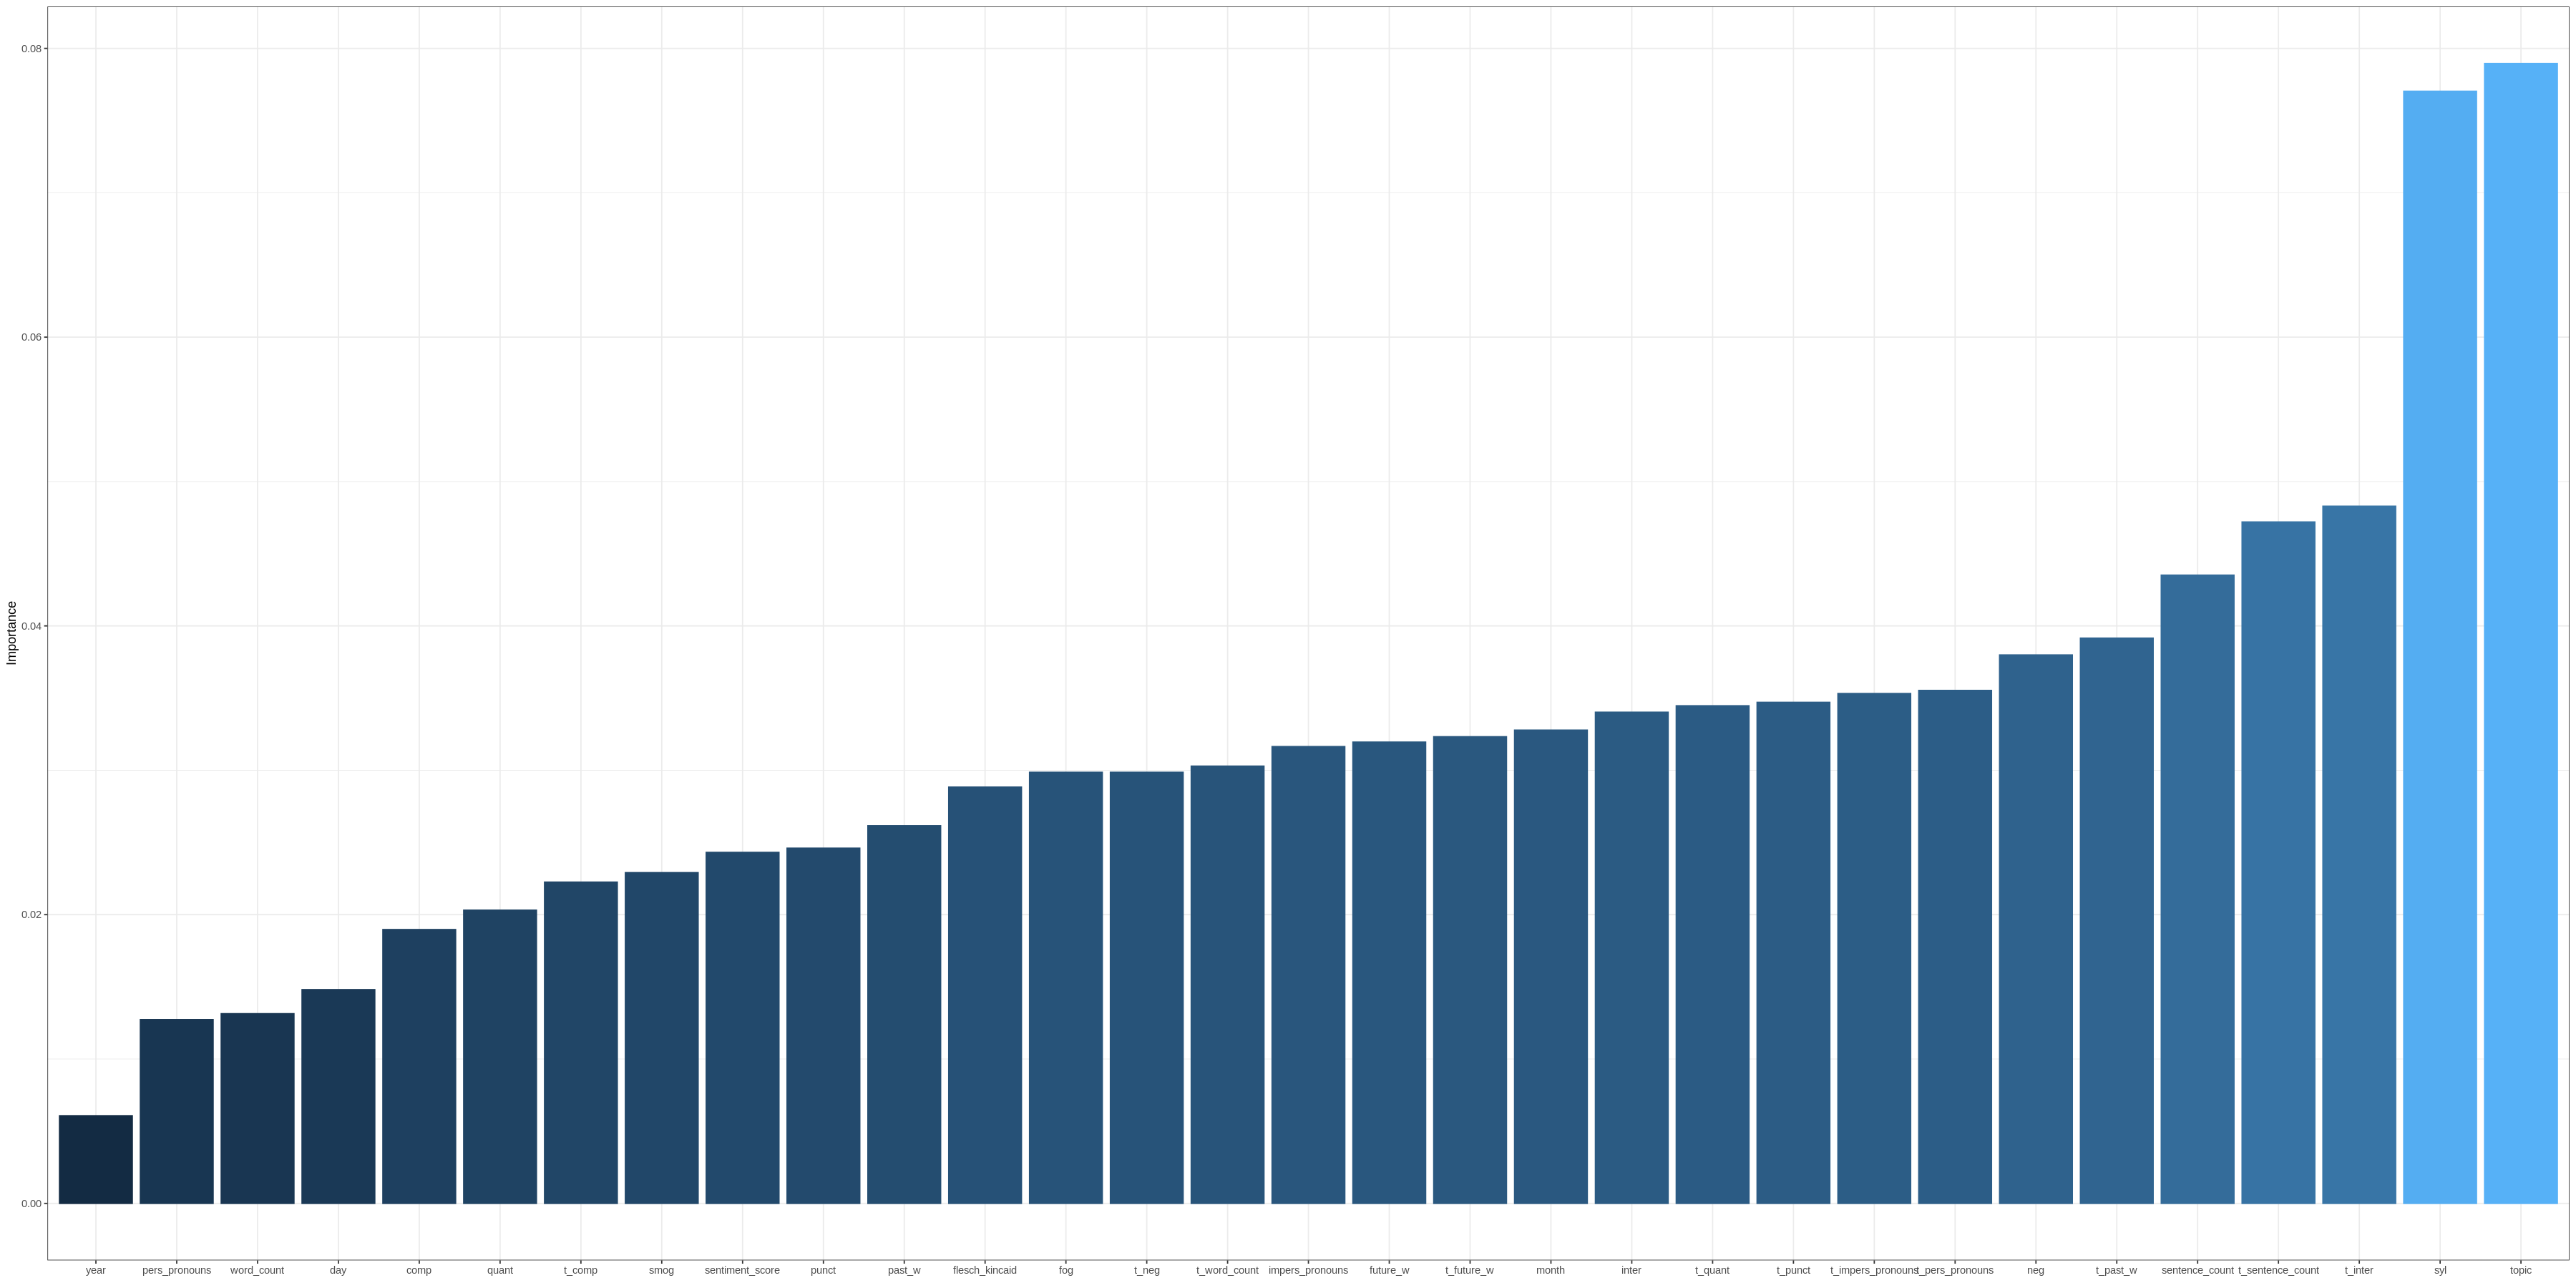

In [ ]:
# Install and load necessary packages
install.packages("nnet")
library(nnet)

# Read the dataset
dt<-read.csv("df_to_model.csv")
dt<-subset(dt, select = -c(X))
dt$label<-as.factor(dt$label)

# Split the data into training and testing sets
set.seed(1234)
train_indices<-createDataPartition(dt$label, p = 0.7, list = FALSE)
train_data<-dt[train_indices, ]
test_data<-dt[-train_indices, ]

# The grid for hyperparameter tuning
grid<-expand.grid(size = c(5, 10, 15, 20, 25, 30, 35), decay = c(0.1, 0.01, 0.001))

# Training the model
set.seed(1234)
nn_model<-train(label~.,
                data = train_data,
                method = "nnet",
                metric = "Accuracy",
                tuneGrid = grid,
                trControl = trainControl(method = "cv",
                                             number = 10,
                                             search = "grid"),
                maxit = 1000)
print(nn_model)
print(nn_model$bestTune) # size = 15, decay = 0.1

# Predict on the test set
nn_preds<-predict(nn_model, newdata = test_data)
conf_matrix<-confusionMatrix(nn_preds, test_data$label)
print(conf_matrix)

# Visualize the ROC curve
nn_probs<-predict(nn_model, newdata = test_data, type = "prob")[, 2]
roc_curve<-roc(test_data$label, nn_probs)
plot(roc_curve, col = "blue", main = "ROC Curve for Neural Network")
auc_value<-auc(roc_curve)
print(auc_value) # 0.9934

# Importance variables
install.packages("NeuralNetTools")
library(NeuralNetTools)
nn_opt_model<-nn_model$finalModel
nn_var_imp<-garson(nn_opt_model, bar_plot = TRUE)
options(repr.plot.width = 30, repr.plot.height = 15)
plot(nn_var_imp)
